In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf



In [2]:
from keras.models import Model,Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [3]:
# Avoid OOM errors by setting GPU Memory Comsumption Growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
print(os.listdir("C:\\Users\\a2-coutodeoliv\\OneDrive - UWE Bristol\\Images\\RF_CNN_img\\RF_CNN_img"))

['test', 'train', 'val']


In [5]:
size = 300

In [6]:
#turn images in greyscale and add them to train list 

train_images = []
train_labels = []
for directory_path in glob.glob("C:\\Users\\a2-coutodeoliv\\OneDrive - UWE Bristol\\Images\\RF_CNN_img\\RF_CNN_img\\train\\*"):
    label = directory_path.split("\\")[-1]
    
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        train_images.append(img)
        train_labels.append(label)

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [8]:
#turn images in greyscale and add them to test list 

test_images = []
test_labels = []

for directory_path in glob.glob("C:\\Users\\a2-coutodeoliv\\OneDrive - UWE Bristol\\Images\\RF_CNN_img\\RF_CNN_img\\test\\*"):
    new_label = directory_path.split("\\")[-1]
    
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        test_images.append(img)
        test_labels.append(new_label)
        
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [9]:
#Encode labels from Text to int
from sklearn import preprocessing 

In [10]:
label_e = preprocessing.LabelEncoder()
label_e.fit(test_labels)
test_labels_encoded = label_e.transform(test_labels)
label_e.fit(train_labels)
train_labels_encoded = label_e.transform(train_labels)

In [11]:
#Split data into test and train datasets 
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [12]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0



In [13]:
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


In [14]:
#Use implement previous CNN Model of our design but only use the Flatten Layer

model = Sequential()
model.add(Conv2D(8, (3,3),(2, 2), activation='relu', input_shape=(300,300,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(16, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(8, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())

x = model.output
x = Dense(2, activation ='linear', activity_regularizer=l1(0.001))(x)
prediction_layer = Dense(1,activation='sigmoid')(x)


In [15]:
#Import relevant packages

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score,accuracy_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import rfecv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer





In [16]:
#Get features from cnn to train the Rf
X_for_RF = model.predict(x_train)
print(X_for_RF.shape)

#Get feature from cnn to test the Rf
X_test_feature = model.predict(x_test)

#X_for_RF = SelectKBest(f_classif, k =100).fit_transform(X_for_RF, y_train)
#X_test_feature =  SelectKBest(f_classif, k =100).fit_transform(X_test_feature, y_test)

print(X_for_RF.shape)
print(X_test_feature.shape)


141/141 [==============================] - 3s 22ms/step
(4483, 128)
18/18 [==============================] - 0s 22ms/step
(4483, 128)
(562, 128)


In [17]:
RF_model =  (RandomForestClassifier(oob_score = True, random_state = 42))
                            
# Train the model on training data                           
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding


RandomForestClassifier(oob_score=True, random_state=42)

In [18]:
#create a F-05 metric score and test different depths and number of trees

params_to_test = {
    'n_estimators':[10,20,30,40,50,60,70,80,90,100],
    'max_depth':[3,6,8,10,12,16,20,24,26]
    
}

def custom_scorer(y_true, y_pred):
    ps = precision_score(y_true, y_pred) 
    rl = recall_score(y_true, y_pred)
    
    f05 =(1.25 * ps * rl)/ (0.25 * ps + rl)
    
    return f05

scorer = make_scorer(custom_scorer, greater_is_better=True)

#here you specify the CV parameters, number of folds, numberof cores to use...
grid_search = GridSearchCV(RF_model, param_grid=params_to_test, cv=10, scoring=scorer, n_jobs=4, )
#Get best features


grid_search.fit(X_for_RF, y_train)

print('Grid best parameter: ', grid_search.best_params_)
print('Grid best f05 score: ', grid_search.best_score_)




#best_params is a dict you can pass directly to train a model with optimal settings 
#best_model = RandomForestClassifier(**best_params)
best_model = grid_search.best_estimator_

Grid best parameter:  {'max_depth': 24, 'n_estimators': 100}
Grid best f05 score:  0.6577692594092829


In [19]:
#cv = StratifiedKFold(5)
#visualizer = rfecv(best_model, X= X_for_RF, y= y_train,cv=cv, scoring= scorer)
#visualizer.show()

Accuracy =  0.6601423487544484


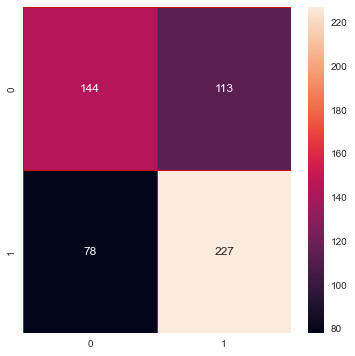

In [20]:

#Now predict using the trained RF model. 
prediction_RF = best_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_RF_1 = label_e.inverse_transform(prediction_RF)

print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF_1))
cm = confusion_matrix(test_labels, prediction_RF_1)


f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, linewidth=.5, linecolor="r", fmt=".0f", ax = ax)
plt.show()

In [21]:
precision = precision_score(y_test,prediction_RF)
recall = recall_score(y_test, prediction_RF)
f05 =(1.25 * precision * recall)/ (0.25 * precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F05:", f05)


Precision: 0.6676470588235294
Recall: 0.7442622950819672
F05: 0.6816816816816816


1/1 [==============================] - 0s 18ms/step
The prediction for this image is:  ['Findings']
The actual label for this image is:  Findings


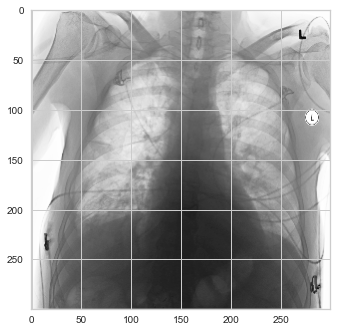

In [22]:
n=92 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features= model.predict(input_img)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = label_e.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])
